In [1]:
import pandas as pd
import numpy as np

In [2]:
#?pd.read_csv

# Read Daily Shareprices and Quarterlöy Income statements (Source SimFin)

In [3]:
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [4]:
sf.set_data_dir('data/')

In [5]:
#sf.load_api_key(path='../../keys/simfin.key', default_key='free')
sf.set_api_key(api_key='free')

In [6]:
df = sf.load(dataset='income', variant='quarterly', market='us')

Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


In [7]:
stock = sf.load(dataset='shareprices', variant='daily', market='us')

Dataset "us-shareprices-daily" not on disk.
- Downloading ... 43.2%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Done!
- Loading from disk ... Done!


# Re-read Files, Parse dates and cleanup column names

In [8]:
df = pd.read_csv("data/us-income-quarterly.csv",sep=';',header=0, parse_dates=[5,6,7])
stock = pd.read_csv("data/us-shareprices-daily.csv",sep=';',header=0, parse_dates=[2])
for s in [' ','.',',','(',')']:
    df.columns = df.columns.str.replace(s, '')
    stock.columns = stock.columns.str.replace(s, '')

/tmp/ipykernel_66945/3552907377.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(s, '')
/tmp/ipykernel_66945/3552907377.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock.columns = stock.columns.str.replace(s, '')


In [9]:
symbol = 'MSFT'

In [10]:
msft = stock[stock.Ticker == symbol].set_index('Date')

In [11]:
df1 = df[df.Ticker == symbol].set_index('PublishDate')

In [12]:
df1['PublishDate'] = df1.index

In [13]:
df1.index.name = 'Date'

In [14]:
ms = msft.join(df1,how='left',rsuffix='inc').fillna(method='ffill')

In [15]:
ms.shape

(3415, 38)

In [16]:
ms = ms[~ms.Tickerinc.isnull()]

In [17]:
ms = ms.dropna(axis=1)

# Create Target to Predict

Target: Adjusted Close of Tomorrow

In [18]:
data = ms

In [19]:
tgt = 'AdjClose'
data[f"{tgt}_s1"] = ms[tgt].shift(-1)

data[f"spread"] = data[f"{tgt}_s1"] - data[tgt]
data[f"target"] = data[f"spread"] > 0

In [20]:
# Create Date/Timebased Features
data['weekday'] = data.index.weekday.astype(float)
data['dayofyear'] = data.index.dayofyear.astype(float)
data['month'] = data.index.month.astype(float)

In [21]:
# Create Hist. targes/values
for var in [f"spread",f"target"]:
    for lag in np.arange(1,10):
        data[f"{var}_lag{lag}"] = data[var].shift(lag)

for var in [f"target"]:
    for lag in np.arange(1,10):
        data[f"{var}_lag{lag}"] = data[var].shift(lag).astype(bool)        

In [22]:
data["Days_Since_Report"] = (data.index-data["PublishDate"]).apply(lambda x: x.days).astype(float)

In [23]:
data["Days_Since_Report"]

Date
2007-01-25     0.0
2007-01-26     1.0
2007-01-29     4.0
2007-01-30     5.0
2007-01-31     6.0
              ... 
2020-07-21    83.0
2020-07-22    84.0
2020-07-23    85.0
2020-07-24    86.0
2020-07-27    89.0
Name: Days_Since_Report, Length: 3400, dtype: float64

In [24]:
data = data.dropna()

In [25]:
data.to_parquet("data/msft.parq")

,Revenue,AdjClose
Revenue,1.000000,0.903231
AdjClose,0.903231,1.000000


<AxesSubplot:label='a2b0da5d-75ea-4211-be57-e9d3da0ad83e', xlabel='Date'>

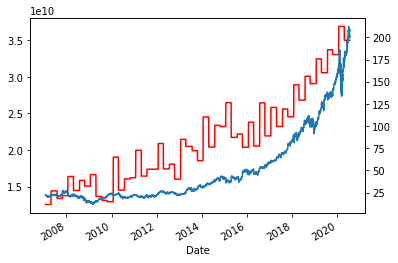

In [26]:
import matplotlib.pyplot as plt
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

display(ms[['Revenue','AdjClose']].corr())
ms['Revenue'].plot(ax=ax,color='red')
ms['AdjClose'].plot(ax=ax2)

,NetIncome,AdjClose
NetIncome,1.000000,0.578724
AdjClose,0.578724,1.000000


<AxesSubplot:label='f37191dc-3f94-42c8-9352-306d6f1f3014', xlabel='Date'>

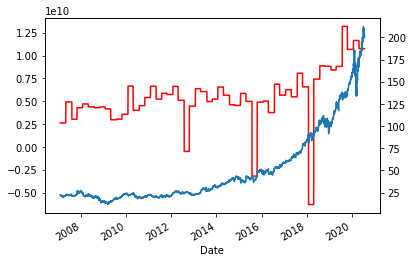

In [27]:
fig,ax = plt.subplots()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

display(ms[['NetIncome','AdjClose']].corr())
ms['NetIncome'].plot(ax=ax,color='red')
ms['AdjClose'].plot(ax=ax2)